In [726]:
# Namespace(adam_beta1=0.9, adam_beta2=0.999, attention_probs_dropout_prob=0.5, attribute_size=131, batch_size=512, cuda_condition=True, data_dir='../../../data/train/', data_file='../../../data/train/train_ratings.csv', data_name='rb', epochs=200, gpu_id='0', hidden_act='gelu', hidden_dropout_prob=0.5, hidden_size=64, initializer_range=0.02, item_size=9337, log_file='output/Finetune_full-rb.txt', log_freq=1, lr=0.0001, mask_id=9336, max_seq_length=300, model_name='Finetune_full', no_cuda=False, num_attention_heads=2, num_hidden_layers=3, output_dir='output/', seed=42, using_pretrain=False, weight_decay=0.0)
# Total Parameters: 791872

# Namespace(adam_beta1=0.9, adam_beta2=0.999, attention_probs_dropout_prob=0.5, attribute_size=131, batch_size=512, cuda_condition=True, data_dir='../../../data/train-6/', data_file='../../../data/train-6/train_ratings.csv', data_name='rb', epochs=200, gpu_id='0', hidden_act='gelu', hidden_dropout_prob=0.5, hidden_size=64, initializer_range=0.02, item_size=9337, log_file='output/Finetune_full-rb.txt', log_freq=1, lr=0.0001, mask_id=9336, max_seq_length=300, model_name='Finetune_full', no_cuda=False, num_attention_heads=2, num_hidden_layers=3, output_dir='output/', seed=42, using_pretrain=False, weight_decay=0.0)
# Total Parameters: 791872

In [727]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler

from datasets import SASRecDataset
from models import S3RecModel
from trainers import FinetuneTrainer

In [728]:
from utils import (
    check_path,
    generate_submission_file,
    get_item2attribute_json,
    get_user_seqs,
    set_seed,
    __save_labels
)

In [729]:
from collections import namedtuple
args = namedtuple("Config", [])

In [748]:
args.data_dir = "../../../data/train-small/"
args.data_dir = "../../../data/train-6/"
# args.output_dir = "output-batch16-hiddensize32/"
# args.output_dir = "output-batch16-hiddensize32-num_attention_heads4/"
# args.output_dir = "output-batch16-hiddensize128-num_attention_heads4/"
args.output_dir = "output-small-batch16-hiddensize64-num_attention_heads2/"
args.output_dir = "output-small-batch16-hiddensize16-num_attention_heads2/"
args.output_dir = "output-small-attnsoft-batch8-hiddensize64-num_attention_heads2/"
args.output_dir = "output-small-attnsoft-batch8-hiddensize8/"
args.output_dir = "output-small-attnsoft-batch4-hiddensize8/"
args.output_dir = "output-small-attnsoft-batch4-hiddensize128/"
args.output_dir = "output-small-attnsoft-batch4-hiddensize128-layers3/"
args.output_dir = "output-small-attnsoft-batch8-hiddensize64-biglr/"
args.output_dir = "output-batch16-hiddensize32/"

args.data_name  = "rb"
args.model_name = "Finetune_full"
args.hidden_size = 32 #64 # hidden size of transformer model
args.num_hidden_layers = 2 #2 # number of layers
args.num_attention_heads = 2 # num_attention_heads
args.hidden_act = "gelu"
args.attention_probs_dropout_prob = 0.5 # attention dropout p
args.hidden_dropout_prob = 0.5 # hidden dropout p
args.initializer_range=0.02
args.max_seq_length= 500 #1000 #500 #50

# train args
args.lr=0.001 # "learning rate of adam"
args.batch_size= 512 #256 # number of batch_size"
args.epochs=200#"number of epochs")
args.log_freq=1 #per epoch print res")
args.seed=42
args.weight_decay=0.0 #, help="weight_decay of adam"
args.adam_beta1=0.9 #"adam first beta value"
args.adam_beta2=0.999 #"adam second beta value"
args.gpu_id="0"#"gpu_id"

In [735]:
set_seed(args.seed)
check_path(args.output_dir) # output_dir 로 설정한 경로가 없으면 생성

In [736]:
args.no_cuda = False # gpu 있음
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
args.cuda_condition = torch.cuda.is_available() and not args.no_cuda

In [737]:
args.data_file = args.data_dir + "train_ratings.csv"
item2attribute_file = args.data_dir + args.data_name + "_item2attributes.json"

In [738]:
# args.data_fil 여기경로를 지나쳐서 index에 관한 정보를 한 번 업데이트하고 지나가자.
# def get_user_seqs(data_file):
# 이거는 training 한정
rating_df = pd.read_csv(args.data_file)



# user_seq, max_item, _, _, submission_rating_matrix = get_user_seqs(args.data_file)
# item2attribute, attribute_size = get_item2attribute_json(item2attribute_file)

# args.item_size = max_item + 2
# args.mask_id = max_item + 1
# args.attribute_size = attribute_size + 1

In [739]:
# le = LabelEncoder()
# if is_train:
#     # For UNKNOWN class
#     a = df[col].unique().tolist() + ["unknown"]
#     le.fit(a)
#     self.__save_labels(le, col)
# else:
#     label_path = os.path.join(self.args.asset_dir, col + "_classes.npy")
#     le.classes_ = np.load(label_path)

#     df[col] = np.where(df[col].isin(le.classes_), df[col], "unknown")


In [740]:
# TODO 이 부분은 학습때 자동 저장되도록 설정해야한다. 
le = LabelEncoder()
# raw_item_list = rating_df["item"].unique().tolist()+ [-99999] # "unknown" -> -99999
# le.fit(raw_item_list)
# __save_labels(args.output_dir, le, "item")

In [741]:
# TODO inference 할 때는, 이런 것들을 불러오도록 해야한다. 

label_path = os.path.join(args.output_dir, "item" + "_classes.npy") # args.asset_dir -> args.output_dir
le.classes_ = np.load(label_path)

In [742]:
rating_df["item"] = le.transform(rating_df["item"])
# le.inverse_transform([1663, 1241, 1446, 5619, 4295, 9335])

In [743]:
# save model args
args_str = f"{args.model_name}-{args.data_name}"

# print(args)

# args.item2attribute = item2attribute

# args.train_matrix = submission_rating_matrix

checkpoint = args_str + ".pt"
args.checkpoint_path = os.path.join(args.output_dir, checkpoint)

# submission_dataset = SASRecDataset(args, user_seq, data_type="submission")
# submission_sampler = SequentialSampler(submission_dataset)
# submission_dataloader = DataLoader(
#     submission_dataset, sampler=submission_sampler, batch_size=args.batch_size
# )

In [744]:
# 따로 저장해야하는 것들
# max_item # 
user_seq, rating_seq, max_item, valid_rating_matrix, test_rating_matrix, _ = get_user_seqs(
    args, # args.data_file, args.output_dir
    is_train = False
)
item2attribute, attribute_size = get_item2attribute_json(item2attribute_file)



In [745]:
args.item_size = max_item + 2
args.mask_id = max_item + 1
args.attribute_size = attribute_size + 1


In [749]:
model = S3RecModel(args=args)

In [750]:
file_name = args.checkpoint_path
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

In [751]:
model = model.to(device="cuda:0")

In [902]:
beer_pick = [5588, 2228, 473, 37, 268, 390, 729, 86387, 1478, 730] # 민철님
beer_pick = [730, 268685, 35424, 2228, 86387, 37] #칭따오, 타이거, 블루문, 블랑, # 아현님 동생분
beer_pick = [251, 2228, 473, 4007, 1267, 86387, 730] # *20 #경태
beer_pick = [614833, 5588, 709, 814, 1267, 37, 315443, 717] #동석님
# beer_pick = [709, 4007, 72025, 814, 37, 399, 390]
# beer_pick = [30913,  814, 4007, 37, 390, 717, 35424] #승태님

input_ids = le.transform(beer_pick).tolist()
input_ratings = [1, 1, 5, 5 ,5, 5, 5, 5, 5, 5]
input_ratings = [5, 5, 1, 1, 1, 5]
input_ratings = [5, 5, 5, 5, 5, 5, 5] # *20
beer_pick = [614833, 5588, 709, 814, 1267, 37, 315443, 717] #동석님
input_ratings = [1, 1, 5, 1, 5, 5, 5, 5]
input_ratings = [-5, -5, 5, -5, 5, 5, 5, 5]
# input_ratings = [1, 5, 5, 1, 5, 5, 5]
# input_ratings = [5, 5, 5, 5, 5, 5, 5]
# input_ratings = [5,5,1,1,1,1,1,1,1,1]
# input_ratings = [5,5,-5,-5,-5,-5,-5,-5,-5,-5] #input_ratings = [5,5,1,1,1,1,1,1,1,1]

pad_len = args.max_seq_length - len(input_ids)
input_ids = [0] * pad_len + input_ids
input_ratings = [0] * pad_len + input_ratings

input_ids = input_ids[-args.max_seq_length :]
input_ratings = input_ratings[-args.max_seq_length :]


input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to("cuda:0")
input_ratings = torch.tensor(input_ratings, dtype=torch.float32).unsqueeze(0).to("cuda:0")

In [903]:
# input_ids
print("input_ids.size ===> ", input_ids.size()) # [batch * max_seq]

# attention_mask
attention_mask = (input_ids > 0).long()
weighted_mask = input_ratings

print("attention_mask.size ===> ", attention_mask.size()) # [batch * max_seq]

# extended_attention_mask
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # torch.int64
extended_weighted_mask = weighted_mask.unsqueeze(1).unsqueeze(2)
print("extended_attention_mask.size ===> ", extended_attention_mask.size()) # [batch * 1 * 1 * max_seq]
print("extended_weighted_mask.size ===> ", extended_weighted_mask.size()) # [batch * 1 * 1 * max_seq]


max_len = attention_mask.size(-1)
print("max_len ==> ", max_len)
attn_shape = (1, max_len, max_len) 
print("attn_shape ==> ", attn_shape)

# subsequent_mask
subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)  # torch.uint8
print(subsequent_mask)
print("======== subsequent_mask =========")
subsequent_mask = (subsequent_mask == 0).unsqueeze(1)
subsequent_mask = subsequent_mask.long().to("cuda:0")
print("subsequent_mask.size ===> ", subsequent_mask.size()) # [batch * 1 * 1 * max_seq] 하위 삼각형이 1이다.
# print(subsequent_mask)


extended_attention_mask = extended_attention_mask * subsequent_mask
weighted_mask_by_score = extended_weighted_mask * subsequent_mask  # 이거는 곱해지는거.
# extended_attention_mask = extended_attention_mask
# print(extended_attention_mask)
print("weighted_mask_by_score")
print(weighted_mask_by_score)

extended_attention_mask
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
print("extended_attention_mask")
print(extended_attention_mask)



input_ids.size ===>  torch.Size([1, 500])
attention_mask.size ===>  torch.Size([1, 500])
extended_attention_mask.size ===>  torch.Size([1, 1, 1, 500])
extended_weighted_mask.size ===>  torch.Size([1, 1, 1, 500])
max_len ==>  500
attn_shape ==>  (1, 500, 500)
tensor([[[0., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
======== subsequent_mask =========
subsequent_mask.size ===>  torch.Size([1, 1, 500, 500])
weighted_mask_by_score
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 5., 0., 0.],
          [0., 0., 0.,  ..., 5., 5., 0.],
          [0., 0., 0.,  ..., 5., 5., 5.]]]], device='cuda:0')
extended_attention_mask
tensor([[[[-10000., -10000., -10000.,  ..., -10000., -

In [904]:
recommend_output = model.finetune(input_ids, input_ratings)
recommend_output = recommend_output[:, -1, :]

In [917]:
result_scores = torch.matmul(model.item_embeddings.weight, recommend_output.transpose(0, 1)).squeeze(1)
result_scores = result_scores.cpu().data.numpy().copy()
input_items = input_ids.cpu().data.numpy().copy()

In [918]:
result_scores = result_scores[1:] # remove "-99999 value('unseen')"

In [907]:
### 6.9.15:15 추가 - 점수 표준화
result_scores[le.transform(target_items)]
df_reg_info = pd.read_csv("reg_info.csv")
df_reg_info["result"] = (result_scores[le.transform(target_items)] - df_reg_info["avg"])/df_reg_info["std"]

<AxesSubplot:>

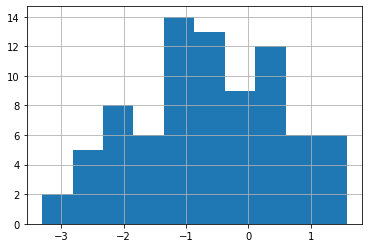

In [908]:
df_reg_info["result"].hist()

In [909]:
df_reg_info.sort_values("result").iloc[-8:]["beer_id"].tolist()
# beer_pick = [614833, 5588, 709, 814, 1267, 37, 315443, 717] #동석님
# input_ratings = [-5, -5, 5, -5, 5, 5, 5, 5]


[614833, 717, 315443, 288954, 405, 251, 715, 86387]

In [877]:
total_result_df = df_reg_info[~df_reg_info["beer_id"].isin(le.inverse_transform(input_items[input_items > 0]))]

In [878]:
total_result_df.sort_values("result").iloc[-8:]["beer_id"].tolist()

[480225, 742, 1417, 291276, 4701, 6668, 72025, 3126]

In [801]:
sorted_items = result_scores.argsort()

# 방금 체크 했던거는 제거
checked_right_before = input_ids[input_ids > 0]
sorted_items = sorted_items[~pd.Series(sorted_items).isin(checked_right_before)]

sorted_items = le.inverse_transform(sorted_items) # 뒤로갈수록 추천해주고 싶은 맥주



array([9336, 9328, 3382, ..., 5247, 6022, 1540])

In [920]:
K=8
sorted_items = result_scores.argsort()

# 방금 체크 했던거는 제거
checked_right_before = input_ids[input_ids > 0]
sorted_items = sorted_items[~pd.Series(sorted_items).isin(checked_right_before)]

sorted_items

array([9336, 9328, 3382, ..., 8538, 7366, 1540])

In [922]:
np.array([1,2,3,4,5,6,10, 16])[np.array([1,2,3,4,5,6,10, 16]).argsort()]

array([ 1,  2,  3,  4,  5,  6, 10, 16])

In [789]:
K=8
sorted_items = result_scores.argsort()

# 방금 체크 했던거는 제거
checked_right_before = input_ids[input_ids > 0]
sorted_items = sorted_items[~pd.Series(sorted_items).isin(checked_right_before)]
# print(sorted_items)
# 원래의 id로 되돌아오기
sorted_items = le.inverse_transform(sorted_items) # 뒤로갈수록 추천해주고 싶은 맥주

In [790]:
# 이것도 DB에서 불러오는 것으로...
filter_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/db_files/db_target_beer.csv")
# filter_df.columns = ["beer_id"]
# target_items = filter_df[filter_df["mik"].isna()]["beer_id"].tolist()
target_items = filter_df["beer_id"].astype(int).tolist()
target_items[:3]

[8666, 75661, 614833]

In [791]:
# target_items = [12769, 71477, 43176, 116553, 7686, 82006] # 우리가 취급할 맥주만 선택: 한국에서 파는 맥주만
sorted_target_items = sorted_items[pd.Series(sorted_items).isin(target_items)]
# sorted_target_items = sorted_items

sorted_target_items_topk = sorted_target_items[-K:]
sorted_target_items_topk

array([146878,    814, 149060,    399,  64253, 136785,   1478, 135361])

<AxesSubplot:>

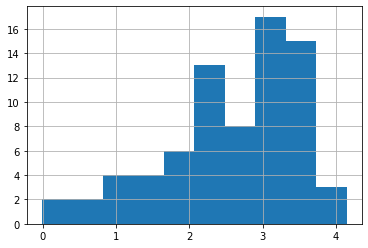

In [792]:

pd.Series(result_scores[le.transform(sorted_target_items)]).hist()

In [725]:
sorted_target_items

array([667837,    405,   8666,  64253,  58275,    399,  15747,   3126,
         2516, 221535, 493355,   7580, 315443,   5159, 268685,   2811,
       136785,   4701, 211962, 480225,   6668,   3101,    221,  75661,
          703, 146878,   5571,  35424,    721,    251,   3029, 169964,
        75071,   7656,    647,  17334,   4007,   1417,  36249, 452525,
        10726,    709,    717, 621308,     55,  72025,  30913, 614833,
       135361, 288954, 146725, 553245,   1267, 149060,  21936,  64518,
        34662, 632627,   1486,  71458, 291276, 506847,   2468,  73158,
          715,  71469,   2469,   1088,   2514,    742,    814])

In [616]:
sorted_target_items

array([667837,    405,   8666,    399,   3126,   2516, 315443,  17334,
        58275,   7580, 221535,  64253,   3101,   6668, 146878,   4007,
       169964, 480225,  15747,   5159,   2811,    251,    221, 136785,
         4701,  75661,    703, 268685, 211962,   5571,    721, 493355,
         3029,  35424,    647,     55,   7656,  75071,   1417,    717,
        36249, 146725, 553245,  10726, 452525,    709, 149060, 135361,
       621308,  72025,   1267,  30913, 632627,  34662, 288954,  21936,
        64518, 614833, 291276,   1486,  71458,  73158,    715,  71469,
       506847,   2468,   1088,   2469,   2514,    814,    742])

In [ ]:
sorted_target_items

array([667837,   3126,    405,    742, 493355, 452525,    703,    268,
       268685,   4701, 315443, 480225,   6668,    721,   5571, 169964,
          729,    709,  75071,     37, 211962, 553245, 621308, 146725,
       632627, 288954,   2811, 614833,    717, 291276,   7656, 221535,
        58275,   2469,   3101,   2516,  21936,    221,  10726,   1417,
           55,   3029, 506847,  71469,  36249,  71458,   5159,   2468,
        35424,  34662,    715,  17334,   8666,  15747,  30913,  72025,
         1088,   7580,    647,  75661,  64518,  64253,   2514,    814,
       146878,  73158,   1486,    399,   5588,    390, 136785, 149060,
         1478, 135361])

In [223]:
sorted_target_items

array([667837,   3126,    405,    703, 268685,    742,   4701, 452525,
       553245, 480225,   6668, 315443, 493355,   5571,    721, 211962,
        75071, 169964, 632627,    268,    729,  58275, 221535,     37,
          709, 146725, 614833, 621308,  36249, 288954,  71458,     55,
         5159, 291276,   7656,  10726,  72025,    221,   1417,   3101,
        21936,   2811,   2516, 506847,  35424,  34662,  71469,    647,
        30913,   1088,    717,    814,   3029,   1486,   2468,   8666,
          715,  17334,  64253,    399,   7580, 136785,  73158,   2514,
        15747,   2469,  64518, 146878,    390,   1478,  75661, 149060,
       135361,   5588])

In [54]:
id2name = {int(beer_id):str(beer_name[0]) for beer_id, beer_name in filter_df[["beer_id", "beer_name"]].set_index("beer_id").iterrows()}

KeyError: "['beer_name'] not in index"

In [52]:
# last result
# filter_df[filter_df["beer_id"].isin(sorted_target_items_topk)]["beer_name"]#.tolist()
[id2name[beer_id] for beer_id in sorted_target_items_topk]


['BINTANG pilsner',
 'XXXX Gold',
 'BrewDog Punk IPA',
 'Tiger Radler Grapefruit',
 'Tsingtao Draft Beer 11º (Pure Draft Beer)',
 'Stephans Brau Larger',
 'Egger Marzenbier',
 "Queen's Ale Blonde Type"]

In [32]:
for i in filter_df[["beer_id", "beer_name"]].set_index("beer_id").iterrows():
    print(i[0], i[1][0])

8666 Ambar Especial
75661 Apostel Brau
614833 Apple Fox
169964 Asahi Super dray Black
251 Asahi super dry
169964 Asahi Super Dry Black
10726 Bali Hai Premium Larger
5588 Barvaria 8.6
5571 Barvaria Premium
703 beck's
6668 Berliner Kindl Pilsener
7656 BINTANG pilsner
2228 Blue Moon Belgian White
135361 BrewDog Punk IPA
473 Budweiser
36249 BURGE MEESTER
709 Carlsberg
12775 Cass Fresh
143730 Cass Light
742 Corona Extra
4007 Desperados
72025 Edelweiss Weissbier Snowfresh
58275 Egger Marzenbier
221535 Egger Radler Grapefruit
291276 Egger Zwickl
2469 Erdinger Dunkel
2468 Erdinger Weissbier
553454 Filite
1088 Franzisaner Hefe-Weissbier
721 Gambrinus Original
30913 Goose Island 312 Urban Wheat Ale
814 Goose Island Goose IPA
75071 Grimbergen Cuvée Blanche
715 Grolsch Premium Larger
1267 Guinness Draught
55 Guinness original
17334 Harbin Beer
37 Heineken
493355 Heineken 0.0
64253 Heineken 3.5%
34662 Heineken Dark Lager
34662 Heineken Dark Lager
136165 Hite D (Dry Finish)
500620 Hite Extra Cold
13

In [254]:
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components=n_components)
tsne_data = tsne.fit_transform(model.item_embeddings.weight.cpu().detach().numpy())
# model.item_embeddings


In [261]:
import matplotlib
import matplotlib.pyplot as plt

df_tsne = pd.DataFrame(tsne_data, columns=["component 0", "component 1"])

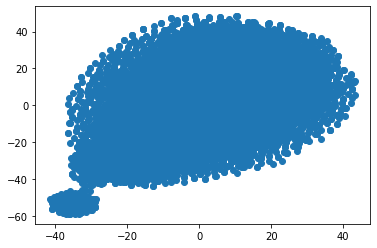

In [263]:
plt.scatter(df_tsne["component 0"], df_tsne["component 1"])

In [264]:
raw_ratebeer = pd.read_json("../../../data/raw_ratebeer.json")
raw_ratebeer = raw_ratebeer.dropna()

In [273]:
df_beer_style = raw_ratebeer.groupby("beer_id")[["beer_id", "style"]].head(1)
df_beer_style.index = range(len(df_beer_style))
le.transform(df_beer_style["beer_id"].astype(int))

ValueError: y contains previously unseen labels: [580686]

In [286]:
df_beer_style = df_beer_style[df_beer_style["beer_id"].isin(le.inverse_transform(rating_df["item"].unique()))]
df_beer_style

,beer_id,style
0,131594.0,Saison / Farmhouse / Grisette
1,121536.0,Specialty Grain - Other
2,12617.0,Pale Lager - American
3,14940.0,IPA - English
4,25933.0,Blonde Ale / Golden Ale
...,...,...
9331,118583.0,Red Ale - Irish
9332,786.0,Amber Lager - International / Vienna
9333,51898.0,Stout - Imperial
9334,5067.0,Red Ale / International Amber Ale


In [289]:
df_beer_style["item"] = le.transform(df_beer_style["beer_id"])

In [290]:
df_beer_style

,beer_id,style,item
0,131594.0,Saison / Farmhouse / Grisette,8940
1,121536.0,Specialty Grain - Other,8692
2,12617.0,Pale Lager - American,3150
3,14940.0,IPA - English,3466
4,25933.0,Blonde Ale / Golden Ale,4350
...,...,...,...
9331,118583.0,Red Ale - Irish,8603
9332,786.0,Amber Lager - International / Vienna,442
9333,51898.0,Stout - Imperial,5695
9334,5067.0,Red Ale / International Amber Ale,1584


In [297]:
inkorea_beer_list = filter_df[filter_df["mik"].isna()]["beer_id"].tolist()
df_beer_style["isinkorea_beer"] = df_beer_style["beer_id"].isin(inkorea_beer_list)

In [299]:
df_beer_style.query("isinkorea_beer == True")

,beer_id,style,item,isinkorea_beer
14,37.0,Pale Lager - International / Premium,24,True
18,55.0,Stout,38,True
63,221.0,Pale Lager - International / Premium,133,True
74,251.0,Pale Lager - International / Premium,149,True
79,268.0,Pale Lager - International / Premium,160,True
...,...,...,...,...
7701,288954.0,Pale Lager - International / Premium,9324,True
8288,553245.0,Pale Ale - American (APA),9331,True
8343,291276.0,Zwickelbier / Kellerbier / Landbier,9325,True
8979,621308.0,Weissbier - Hefeweizen,9333,True


In [323]:
df_tsne = df_tsne.reset_index()
df_tsne.columns = ["item", "component 0", "component 1"]
df_tsne = df_tsne.merge(df_beer_style, on = "item", how = "left")

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

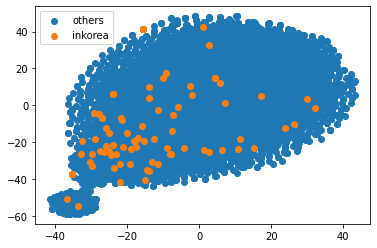

In [333]:
df_tsne_common = df_tsne.query("isinkorea_beer == False")
plt.scatter(df_tsne_common["component 0"], df_tsne_common["component 1"], label = "others")
df_tsne_inkorea = df_tsne.query("isinkorea_beer == True")
plt.scatter(df_tsne_inkorea["component 0"], df_tsne_inkorea["component 1"], label = "inkorea")
plt.legend()
plt.show()

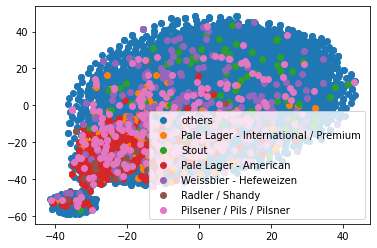

In [342]:
df_tsne_common = df_tsne.query("isinkorea_beer == False")
plt.scatter(df_tsne_common["component 0"], df_tsne_common["component 1"], label = "others")
df_tsne_inkorea = df_tsne#.query("isinkorea_beer == True")
df_tsne_inkorea0 = df_tsne_inkorea.query("style == 'Pale Lager - International / Premium'")
plt.scatter(df_tsne_inkorea0["component 0"], df_tsne_inkorea0["component 1"], label = "Pale Lager - International / Premium")
df_tsne_inkorea1 = df_tsne_inkorea.query("style == 'Stout'")
plt.scatter(df_tsne_inkorea1["component 0"], df_tsne_inkorea1["component 1"], label = "Stout")
df_tsne_inkorea2 = df_tsne_inkorea.query("style == 'Pale Lager - American'")
plt.scatter(df_tsne_inkorea2["component 0"], df_tsne_inkorea2["component 1"], label = "Pale Lager - American")
df_tsne_inkorea3 = df_tsne_inkorea.query("style == 'Weissbier - Hefeweizen'")
plt.scatter(df_tsne_inkorea3["component 0"], df_tsne_inkorea3["component 1"], label = "Weissbier - Hefeweizen")
df_tsne_inkorea4 = df_tsne_inkorea.query("style == 'Radler / Shandy'")
plt.scatter(df_tsne_inkorea4["component 0"], df_tsne_inkorea4["component 1"], label = "Radler / Shandy")
df_tsne_inkorea5 = df_tsne_inkorea.query("style == 'Pilsener / Pils / Pilsner'")
plt.scatter(df_tsne_inkorea5["component 0"], df_tsne_inkorea5["component 1"], label = "Pilsener / Pils / Pilsner")
plt.legend()
plt.show()

In [339]:
df_beer_style.query("isinkorea_beer == True")["style"].value_counts()

Pale Lager - International / Premium    26
Weissbier - Hefeweizen                   8
Pale Lager - American                    7
Radler / Shandy                          5
Pilsener / Pils / Pilsner                5
Witbier / Belgian White Ale              5
Apple Cider                              2
IPA                                      2
Pilsener - Bohemian / Czech              2
Dark Lager - International / Premium     2
Märzen / Oktoberfest Bier                1
Pale Ale - American (APA)                1
Stout                                    1
Pilsener - Imperial                      1
IPA - English                            1
Weissbier - Dunkelweizen                 1
Flavored - Other                         1
Low / No Alcohol Beer - Pale             1
Belgian Ale - Pale / Golden / Single     1
Flavored - Fruit                         1
Stout - Dry / Irish                      1
Amber Lager - International / Vienna     1
Wheat Ale                                1
Zwickelbier